In [1]:
%pylab notebook
from time import sleep
import sys
rcParams["axes.grid"] = True

sys.path.append("..")
from common import *

sys.path.append("../linux/csr_access/py/")
from csr_lib import CsrLib, CsrLibLegacyAdapter
from vvm_helpers import initLTC, getSamples, getNyquist, meas_f_ref, twos_comps

from socket_instrument import SocketInstrument

Populating the interactive namespace from numpy and matplotlib


# Connect and init VVM

In [2]:
r = conLitexServer('../../build/csr.csv')
c = CsrLibLegacyAdapter(r)
print("f_sample:", r.regs.lvds_f_sample_value.read() / 1e6, "MHz")
initLTC(c)

Connected to Port 1234
Zedboard RF vector volt-meter 2020-01-06 12:30:34
f_sample: 117.600744 MHz
Resetting LTC
autoBitslip(): aligned after 4
ID: 16  F: 11110000
CH0: 0000000000000001
CH1: 0000000000000001
CH2: 0000000000000001
CH3: 0000000000000001
autoIdelay(): min = 9, mean = 15, max = 21 idelays


# Setup VVM parameters

In [9]:
# Frequency / bandwidth setting
vvm_ddc_deci = 100  # vvm_ddc_decimation factor
vvm_ddc_shift = 2
f_sample = 117.6e6  # Sampling clock frequency
Ms = (1, 1, 1, 1) # Measurement harmonic
iir_shift = 2

# Setup vvm_ddc_decimation factor
r.regs.vvm_ddc_deci.write(vvm_ddc_deci)

# Throw away N bits after CIC to avoid saturation with large vvm_ddc_deci factors
# This will change the scaling!
r.regs.vvm_ddc_shift.write(vvm_ddc_shift)

# IIR result averaging filter smoothing factor (0 - 15)
r.regs.vvm_iir.write(iir_shift)
   
print('f_sample', r.regs.lvds_f_sample_value.read() / 1e6, "MHz")
print('f_ref', meas_f_ref(c, f_sample) / 1e6, "MHz")
print('vvm_ddc_deci', r.regs.vvm_ddc_deci.read())
print('bw', f_sample / vvm_ddc_deci / 1e6, "MHz")
print('iir_shift', r.regs.vvm_iir.read())

f_sample 117.600742 MHz
f_ref 8.293005 MHz
vvm_ddc_deci 100
bw 1.176 MHz
iir_shift 2


In [10]:
def getMags():
    ''' [dbFs] '''
    mags = zeros(4)
    for i in range(len(mags)):
        val = getattr(r.regs, "vvm_mag{}".format(i)).read()
        val = val / (1 << 21) * (1 << (vvm_ddc_shift - 1))
        mags[i] = val
    return 20 * log10(mags)

def getPhases():
    phs = zeros(3)
    for i in range(3):
        val = getattr(r.regs, "vvm_phase{}".format(i + 1)).read()
        val = twos_comps(val, 32)
        val = val / (1 << 21) * 180
        phs[i] = val
    return phs

def set_center_freq(f_ref):
    ftw = int(((f_ref / f_sample) % 1) * 2**32)
    # Setup center frequency / measurement harmonic
    for i, mult in enumerate(Ms):
        ftw_ = int(ftw * mult)
        getattr(r.regs, 'vvm_ddc_dds_ftw{}'.format(i)).write(ftw_)
        if i > 0:
            getattr(r.regs, 'vvm_pp_mult{}'.format(i)).write(mult)
    r.regs.vvm_ddc_dds_ctrl.write(0x2)  # FTW_UPDATE

def doSweep(f_test):
    mags = []
    phases = []
    for f in f_test:
        s.write("SOURCE:FREQUENCY {:}".format(f))
        set_center_freq(f)
        sleep(.1)
        mags.append(getMags())
        phases.append(getPhases())
    mags = vstack(mags)
    phases = vstack(phases)
    return mags, phases

In [11]:
set_center_freq(10e6)

In [12]:
getMags()

array([-92.80777343,  -0.21118337, -92.45319809, -90.3089987 ])

In [ ]:
getPhases()

# Connect to RS SMA100A

In [13]:
s = SocketInstrument("128.3.131.26", 5025)
s.__enter__()

In [14]:
s.ask("*IDN?")

'Rohde&Schwarz,SMA100A,1400.0000k02/111390,3.1.19.15-3.50.057.29'

# Do a frequency sweep

In [ ]:
f_test = linspace(10e6, 800e6, 500)
p_test = 10.0 # [dBm]

# Filter out frequencies too close to 0 Hz or fSample / 2
f_thr = 1e6
bad_inds = zeros_like(f_test, dtype=bool)
for i in range(16):
    bad_f = f_sample / 2 * i
    bad_inds |= abs(f_test - bad_f) < f_thr
# bad_inds

# f_test = f_test[~bad_inds]
mag_results = zeros((len(f_test), 4))

In [ ]:
CH = 3
mags, phases = doSweep(f_test)
mag_results[:, CH] = mags[:, CH]

In [ ]:
close()
fig, ax = subplots(1, 1)

# for f in f_test[bad_inds]:
#     ax.axvline(f, color="red", alpha=0.5)

for i in range(mag_results.shape[1]):
    ax.plot(f_test[~bad_inds], mag_results[~bad_inds, i], label="Channel {:}".format(i))
    
ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("Raw Magnitude [dBfs]")
ax.legend()

# Measure cable insertion loss

In [ ]:
from skrf import Network, Frequency

In [ ]:
def getS21(s2p_file, f_test):
    cab = Network(s2p_file)
    cab.resample(Frequency.from_f(f_test, unit="Hz"))
#     print(cab)
#     close()
#     cab.plot_s_db(1,0)
    return 20 * log10(abs(cab.s[:, 1, 0]))
#     return abs(cab.s[:, 1, 0])

In [ ]:
p_test_cor[:10]

In [ ]:
cab_s21mag = getS21('vna/CAB.S2P', f_test)
p_test_cor = p_test + cab_s21mag  # [dBm]

In [ ]:
cor_facts_dBm = atleast_2d(p_test_cor).transpose() - mag_results

In [ ]:
mag_results + cor_facts_dBm

# Save cal file

In [ ]:
savez(
    "cal1.npz", 
    f_test=f_test, 
    mag_results=mag_results, 
    bad_inds=bad_inds,
    vvm_ddc_deci=vvm_ddc_deci,
    vvm_ddc_shift=vvm_ddc_shift,
    f_sample=f_sample,
    Ms=Ms,
    iir_shift=iir_shift,
    cab_s21mag=cab_s21mag,
    p_test=p_test
)

# Load cal file

In [88]:
class MagCal:
    def __init__(self, cal_file):
        ''' cal_file must be in .npz format '''
        self.d = d = load(cal_file)
        self.cal_facts_db = atleast_2d(d['p_test'] + d['cab_s21mag']).transpose() - d['mag_results']
        self.cal_freqs = d['f_test']       

    def get_mag_cal(self, f):
        ''' return closest available 4 channel magnitude correction factors [dB] '''
        corInd = argmin(abs(self.cal_freqs - f))
        return self.cal_facts_db[corInd]

    def correct_mags(self, mags, f_test):
        ''' correct an array of 4 channel magnitude measurements, measured at f_test '''
        mags_cor = zeros_like(mags)
        for i, (m, f) in enumerate(zip(mags, f_test)):
            mags_cor[i, :] = m + self.get_mag_cal(f)
        return mags_cor

In [89]:
cal = MagCal('cal1.npz')

In [86]:
f_test = linspace(10e6, 800e6, 50)
mags, phases = doSweep(f_test)
mags_cor = cal.correct_mags(mags, f_test)

<IPython.core.display.Javascript object>


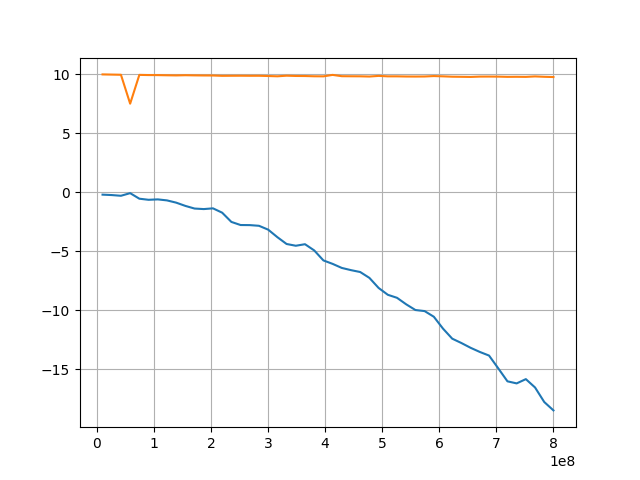

In [90]:
plot(f_test, mags[:,1])
plot(f_test, mags_cor[:,1])

In [96]:
getPhases()

array([-125.97541809,  -47.09323883,   39.20685768])